<a href="https://colab.research.google.com/github/Sanali138/MyProject/blob/master/SuperResolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Enhanced image saved to /content/drive/MyDrive/Colab Notebooks/enhanced_images/malignant_ductal_carcinoma_SOB_M_DC_14-9461_40X_to_100X_super_res_enhanced.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Enhanced image saved to /content/drive/MyDrive/Colab Notebooks/enhanced_images/malignant_ductal_carcinoma_SOB_M_DC_14-9461_40X_to_100X_super_res_enhanced.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Enhanced image saved to /content/drive/MyDrive/Colab Notebooks/enhanced_images/malignant_ductal_carcinoma_SOB_M_DC_14-9461_40X_to_100X_super_res_enhanced.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Enhanced image saved to /content/drive/MyDrive/Colab Notebooks/enhanced_images/malignant_ductal_carcinoma_SOB_M_DC_14-9461_40X_to_100X_super_res_enhanced.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Enhanced image saved to /content/drive/MyDrive/Colab Notebooks/enhanced_images/malignant_ductal_carcinoma_SOB_M_DC_14-9461_40X_to_100X_super_res_enhanced.png


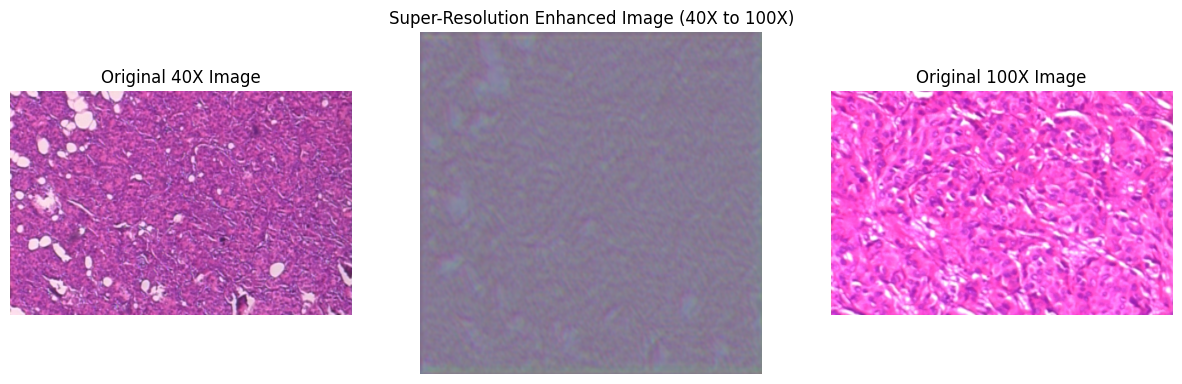

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Enhanced image saved to /content/drive/MyDrive/Colab Notebooks/enhanced_images/malignant_ductal_carcinoma_SOB_M_DC_14-9461_40X_to_100X_super_res_enhanced.png


KeyboardInterrupt: 

In [1]:
from google.colab import drive
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, Add, BatchNormalization, Activation
from tensorflow.keras.models import Model

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)


dataset_dir = '/content/drive/MyDrive/Colab Notebooks/BreaKHis_v1/BreaKHis_v1/histology_slides/breast'
output_dir = '/content/drive/MyDrive/Colab Notebooks/enhanced_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)


tumor_types = {
    'malignant': ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma'],
    'benign': ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma']
}

target_resolution = (224, 224)

def create_custom_sr_model(input_shape=(None, None, 3), upscale_factor=2):
    inputs = Input(shape=input_shape)

    # Initial Convolution Layer with more filters
    x = Conv2D(128, (9, 9), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Increase the number of Residual Blocks
    for _ in range(4):  # Adding more residual blocks
        res = Conv2D(128, (3, 3), padding='same')(x)
        res = BatchNormalization()(res)
        res = Activation('relu')(res)
        res = Conv2D(128, (3, 3), padding='same')(res)
        res = BatchNormalization()(res)
        x = Add()([x, res])

    # Upsampling Layer
    x = UpSampling2D(size=(upscale_factor, upscale_factor), interpolation='bilinear')(x)

    # Final Convolution Layer for output with sigmoid activation
    x = Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)
    x = BatchNormalization()(x)

    model = Model(inputs, x)
    return model

custom_sr_model = create_custom_sr_model()

def apply_light_smoothing(img, kernel_size=(3, 3)):
    return cv2.GaussianBlur(img, kernel_size, 0)

def apply_histogram_equalization(img):
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = list(cv2.split(img_lab))  # Convert tuple to list
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])  # Apply CLAHE on the L-channel
    img_lab = cv2.merge(lab_planes)  # Merge the modified LAB channels back
    img_equalized = cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)
    return img_equalized


def apply_denoising(img):
    return cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

def apply_custom_super_resolution(image, sr_model):
    img = np.expand_dims(image, axis=0)
    img_sr = sr_model.predict(img)
    img_sr = np.clip(img_sr[0], 0, 1)
    return img_sr

def load_transform_and_save_images_40X_to_100X(dataset_dir, tumor_types, output_dir):
    image_counter = 0
    for tumor_type, subdirs in tumor_types.items():
        for subdir in subdirs:
            tumor_dir = os.path.join(dataset_dir, tumor_type, 'SOB', subdir)
            if not os.path.exists(tumor_dir):
                print(f"Directory not found: {tumor_dir}")
                continue

            for case_id in os.listdir(tumor_dir):
                case_dir = os.path.join(tumor_dir, case_id)
                if os.path.isdir(case_dir):
                    magnification_dir_40X = os.path.join(case_dir, '40X')
                    magnification_dir_100X = os.path.join(case_dir, '100X')
                    if os.path.exists(magnification_dir_40X) and os.path.exists(magnification_dir_100X):
                        for root, dirs, files in os.walk(magnification_dir_40X):
                            for file in files:
                                image_path_40X = os.path.join(root, file)
                                image_path_100X = os.path.join(magnification_dir_100X, file.replace('40', '100'))

                                try:
                                    img = cv2.imread(image_path_40X)
                                    if img is None:
                                        print(f"Could not load image: {image_path_40X}")
                                        continue

                                    # Resize image to a consistent size for model compatibility
                                    img = cv2.resize(img, target_resolution)

                                    # Apply histogram equalization
                                    img = apply_histogram_equalization(img)

                                    # Apply denoising
                                    img = apply_denoising(img)

                                    # Convert image to float32 and normalize for model compatibility
                                    img = img.astype(np.float32) / 255.0

                                    # Apply super-resolution
                                    img_transformed = apply_custom_super_resolution(img, custom_sr_model)

                                    # Apply light smoothing (optional)
                                    img_transformed = apply_light_smoothing(img_transformed)

                                    # Convert image back to uint8 for saving
                                    img_transformed = (img_transformed * 255).astype(np.uint8)

                                    # Save the enhanced image
                                    output_filename = f'{tumor_type}_{subdir}_{case_id}_40X_to_100X_super_res_enhanced.png'
                                    output_path = os.path.join(output_dir, output_filename)
                                    cv2.imwrite(output_path, img_transformed)
                                    print(f"Enhanced image saved to {output_path}")

                                    # Visualize every 5th image
                                    image_counter += 1
                                    if image_counter % 5 == 0:
                                        plt.figure(figsize=(15, 5))

                                        # Original 40X Image
                                        img_original_40X = cv2.imread(image_path_40X)
                                        img_original_40X = cv2.cvtColor(img_original_40X, cv2.COLOR_BGR2RGB)
                                        plt.subplot(1, 3, 1)
                                        plt.imshow(img_original_40X)
                                        plt.title("Original 40X Image")
                                        plt.axis('off')

                                        # Enhanced Super-Resolution Image
                                        img_enhanced = cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB)
                                        plt.subplot(1, 3, 2)
                                        plt.imshow(img_enhanced)
                                        plt.title("Super-Resolution Enhanced Image (40X to 100X)")
                                        plt.axis('off')

                                        # Original 100X Image
                                        img_original_100X = cv2.imread(image_path_100X)
                                        if img_original_100X is not None:
                                            img_original_100X = cv2.cvtColor(img_original_100X, cv2.COLOR_BGR2RGB)
                                            plt.subplot(1, 3, 3)
                                            plt.imshow(img_original_100X)
                                            plt.title("Original 100X Image")
                                            plt.axis('off')

                                        plt.show()

                                except Exception as e:
                                    print(f"Error processing {image_path_40X}: {e}")

# Run the processing function
load_transform_and_save_images_40X_to_100X(dataset_dir, tumor_types, output_dir)